# Capacitated Vehicle Routing Problem (CVRP)



Example of CVRP implemented suing CPLEX as solver. The optimisation code is adapted for that of the great tutorials by [Sergio Correa](https://www.youtube.com/channel/UCGyGH1nuNrR1C35kWN9BMAg).

* From address -> get latitude and longitude with google geocode API
* Create distance matrix calculating distances with google distance API (store duration/distance and polylines for plotting)
* Solve optimisation problem
* Display results with Folium and the TimestampedGeoJson plugin


### Libraries

In [1]:
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import math
import pickle

from docplex.mp.model import Model

import networkx
import folium
import geopy
from datetime import datetime
import googlemaps
from geopy.geocoders import Bing 
from folium.plugins import TimestampedGeoJson
import polyline


#Google API
gkey='insert key here'
gmaps = googlemaps.Client(key=gkey)
#Bing API
bkey='insert key here'
b=Bing(bkey,timeout=5)


In [2]:
def google_geocode(address):
    """ use google api to latitude and longitude """
    geocode_result = gmaps.geocode(address)
    location = geocode_result[0]['geometry']['location']
    formatted_address = geocode_result[0]['formatted_address']
    
    return location,formatted_address

In [3]:
def get_distance_bing(lat0,lon0,lat1,lon1):
    """ use bing api to get pairwise distance in km """
    routeUrl = "http://dev.virtualearth.net/REST/V1/Routes/Driving?wp.0=" + str(lat0) + "," + str(lon0) + "&wp.1=" +  str(lat0) + "," + str(lon1)  + "&key=" + key
    print(routeUrl)
    request = urllib.request.Request(routeUrl)
    response = urllib.request.urlopen(request,timeout=15)
    a=response.read().decode(encoding="utf-8")
    result = json.loads(a)
    distance=result["resourceSets"][0]["resources"][0]["travelDistance"]
        
    return distance

In [4]:
def get_distance_gmaps(lat0,lon0,lat1,lon1):
    """ use google api to calculate pairwise driving distanc, traffic is based on 'now' """
    now = datetime.now()
    directions_result = gmaps.directions([lat0,lon0],[lat1,lon1], mode="driving",departure_time=now)
    dm = directions_result[0]['legs'][0]['distance']['value'] #total distance in m
    ds = directions_result[0]['legs'][0]['duration']['value'] #duration (not considering traffic)
    dp = directions_result[0]['overview_polyline']['points'] #for plotting total polyline
    return dm,ds,dp

In [5]:
# Note: index zero is the location of the depot
df = pd.read_excel('/Users/Marcello/Documents/Pizza_san_felice_API.xlsx',index_col=[0])
df.head()

,Nome,Indirizzo,Quantita,Location,Latitude,Longitude
Numero,,,,,,
0,El Patio,"Via G. Zanardelli, 5, 25010 San Felice del Ben...",NaN,"Via Giuseppe Zanardelli, 5, 25010 San Felice d...",45.585626,10.548561
1,Marcello,"Via dei Pescatori, 12,25010 San Felice del Ben...",2.0,"Via dei Pescatori, 12, 25010 San Felice del Be...",45.593915,10.557452
2,Maria,"Via dei Lauri, 1, 25010 San Felice del Benaco ...",2.0,"Via dei Lauri, 1, 25010 San Felice del Benaco ...",45.595410,10.536450
3,Giovanni,"Via Boschette, 18, 25010 San Felice del Benaco...",4.0,"Via Boschette, 18, 25010 San Felice del Benaco...",45.593250,10.540260
4,Pina,"Viale Italia, 14, 25010 San Felice del Benaco ...",5.0,"Viale Italia, 14, 25010 San Felice del Benaco ...",45.587504,10.550529


In [6]:
# If not empty (i.e. non nan, default from loading empty cells in excel) use API geocode function
df['Location']=df.apply(lambda x: x['Location'] if isinstance(x['Location'], str) else google_geocode(x['Indirizzo']), axis=1)

# Populate table
df['Latitude']=df.apply(lambda x: x['Latitude'] if not math.isnan(x['Latitude']) else x['Location'][0]['lat'], axis=1)
df['Longitude']=df.apply(lambda x: x['Longitude'] if not math.isnan(x['Longitude']) else x['Location'][0]['lng'], axis=1)
df['Location']=df.apply(lambda x: x['Location'] if len(x['Location'])>2 else x['Location'][1], axis=1)


### Plot Map

In [7]:
m = folium.Map(
    location=[45.58534, 10.55186],
    zoom_start=13
)

df.apply(lambda x:folium.CircleMarker(location=[x["Latitude"], x["Longitude"]], radius=10).add_to(m), axis=1)
m


### Define the optimisation problem

In [8]:
#clients tot - depot
n=df.shape[0]-1
clients=[i for i in range(1,n+1)]
#nodes
nodes=[0] + clients
#capacity van
C=30
#arcs
arcs=[(i,j) for i in nodes for j in nodes if i!=j]

q={i:np.random.randint(1,10) for i in clients}

print('Clients =' + str(n))
print('# Arcs = ' + str(len(arcs)))


Clients =25
# Arcs = 650


### Compute Distance Matrix

Store three dictionaries with distance in seconds, meters and a polylne for each arc.

In [ ]:
dist_s={} #dictionary with distance in seconds
dist_m={} #dictionary with distance in seconds
dist_p={} #dictionary with polylines for plotting

for i in arcs:
    s,m,p=get_distance_gmaps(df['Latitude'][i[0]],df['Longitude'][i[0]],df['Latitude'][i[1]],df['Longitude'][i[1]])
    dist_s[i] = s
    dist_m[i] = m
    dist_p[i] = p

out=[dist_s,dist_m,dist_p]

with open("distance_matrix.txt", "wb") as f:
    pickle.dump(out, f)

In [13]:
with open("distance_matrix.txt", "rb") as f: 
    dist_mat_list = pickle.load(f)

distance=dist_mat_list[0]

### Run optimization problem

In [14]:
mdl=Model('CVRP')

mdl.parameters.timelimit=120 #Two minutes timeout if does not reach a optimal solution

x=mdl.binary_var_dict(arcs,name='x')
u=mdl.continuous_var_dict(nodes,ub=C,name='u')
# cost function is to minimize tot distance (could minimize time or a combined score)
mdl.minimize(mdl.sum(distance[i,j]*x[i,j] for i,j in arcs )) 

In [15]:
# Add contrains for CVRP
mdl.add_constraints(mdl.sum(x[i,j] for j in nodes if i!=j)==1 for i in clients);
mdl.add_constraints(mdl.sum(x[i,j] for i in nodes if i!=j)==1 for j in clients);
mdl.add_constraints(u[i]>=q[i] for i in clients);
mdl.add_indicator_constraints(mdl.indicator_constraint(x[i,j],u[i]+q[j]==u[j])
                              for i,j in arcs if i!= 0 and  j!= 0);

In [ ]:
# Print model
print(mdl.export_to_string())

In [ ]:
solution=mdl.solve(log_output=True)

In [18]:
mdl.get_solve_status()

<JobSolveStatus.FEASIBLE_SOLUTION: 1>

In [ ]:
solution.display()

### Plotting Results

Start with topology to visualize crossings

/Users/Marcello/anaconda3/envs/py37/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


[[0, 6, 10, 4, 23, 0],
 [0, 1, 25, 14, 18, 19, 16, 15, 0],
 [0, 22, 17, 21, 13, 0],
 [0, 5, 20, 11, 12, 0],
 [0, 3, 2, 8, 24, 7, 0]]

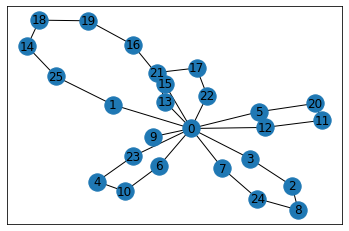

In [21]:
#Arcs that are actually travelled
active_arcs = [a for a in arcs if x[a].solution_value > 0.9]

G=networkx.Graph(active_arcs)
labels = dict(zip(G.nodes(),G.nodes()))

networkx.draw_networkx(G,labels=labels)
networks=networkx.cycle_basis(G,0)
networks = [[0]+i for i in networks] 
networks

Now plot results with actual driven route

In [22]:
geo_list=[]
times=dist_mat_list[1]
poly=dist_mat_list[2]

colors=['red','green','blue','black','tomato','coral','grey']
t=0
ot=1587575480566

for i,j in enumerate(networks):

    print(j)
    for k in range(0,len(j)-1):
        temp={}
        t=t+3600000
        idx=poly.get((j[k],j[k+1]))
        pp=polyline.decode(idx)
        swap=[ [pp[i][1],pp[i][0]] for i in range(0,len(pp)) ] #because geojson wants Lng and Lat in order
        temp['coordinates']=swap
        temp['dates']=[ot+t, ot+500+t]*len(pp)
        temp['color']=colors[i]
        geo_list=geo_list+[temp]
              
features = [
    {
        'type': 'Feature',
        'geometry': {
            'type': 'LineString',
            'coordinates': line['coordinates'],
        },
        'properties': {
            'times': line['dates'],
            'style': {
                'color': line['color'],
                'weight': line['weight'] if 'weight' in line else 3
            }
        }
    }
    for line in geo_list
]


#Create Folium Map
m = folium.Map(
    location=[45.58534, 10.55186],
    zoom_start=13
)

df.apply(lambda x:folium.CircleMarker(location=[x["Latitude"], x["Longitude"]], radius=10).add_to(m), axis=1)

TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features,
}, period='PT1H', add_last_point=False).add_to(m)

m  

[0, 6, 10, 4, 23, 0]
[0, 1, 25, 14, 18, 19, 16, 15, 0]
[0, 22, 17, 21, 13, 0]
[0, 5, 20, 11, 12, 0]
[0, 3, 2, 8, 24, 7, 0]


In [ ]:
# Save screeshots to make a gif

import os
import time
from selenium import webdriver

delay=10
fn='map_it.html'
tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
m.save(fn)

browser = webdriver.Firefox()
browser.get(tmpurl)
#Give the map tiles some time to load
time.sleep(delay)
for i in range(0,100):
    browser.save_screenshot('map' +str(i) + '.png')
browser.quit()

### Verify solution with all permutations (only for TSP case n<20)

In [ ]:
import itertools 
import math

minLength = math.inf 
minTour = []

for tour in itertools.permutations(list(range(1,n))):
    #print(tour)
    fr = 0
    length = 0
    count = 0
    while count < n-1:
        to = tour[count]
        length += distance[fr,to]  
        fr = to
        count += 1
    length += distance[fr,0] 
    #print(length)
    if length < minLength: 
        minLength = length
        minTour = tour

minTour = (0,) + minTour + (0,) 
print('Shortest tour is:', minTour)
print('It has a length of:', minLength, 'km')